# Carol Zhang

## Research Question/Interests

### Economic Analysis of Road Accidents 

Accidents can cause significant economic burdens on individuals, insurance providers, and governments. These costs can include direct responses such as medical treatment and vehicle damage and indirect costs like lost productivity and emergency response expenditures. Understanding the financial impact of accidents is crucial for policymakers to design cost-effective solutions and allocate resources efficiently to reduce the frequency and severity of accidents. 

### Key Research Questions
- Which accident-related factors contribute the most to economic loss, and how does their impact vary by accident severity?
- How do medical costs and total economic loss per accident differ between urban and rural areas? 
- Do speed limits impact the medical costs and economic loss associated with road accidents?

## EDA

#### Imports

In [1]:
import os
import altair as alt
import pandas as pd
from toolz.curried import pipe

# Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

#### Load in Data

In [2]:
accidents = pd.read_csv('../../data/raw/road_accident_dataset.csv')
accidents.head()

,Country,Year,Month,Day of Week,Time of Day,Urban/Rural,Road Type,Weather Conditions,Visibility Level,Number of Vehicles Involved,...,Number of Fatalities,Emergency Response Time,Traffic Volume,Road Condition,Accident Cause,Insurance Claims,Medical Cost,Economic Loss,Region,Population Density
0,USA,2002,October,Tuesday,Evening,Rural,Street,Windy,220.414651,1,...,2,58.625720,7412.752760,Wet,Weather,4,40499.856982,22072.878502,Europe,3866.273014
1,UK,2014,December,Saturday,Evening,Urban,Street,Windy,168.311358,3,...,1,58.041380,4458.628820,Snow-covered,Mechanical Failure,3,6486.600073,9534.399441,North America,2333.916224
2,USA,2012,July,Sunday,Afternoon,Urban,Highway,Snowy,341.286506,4,...,4,42.374452,9856.915064,Wet,Speeding,4,29164.412982,58009.145124,South America,4408.889129
3,UK,2017,May,Saturday,Evening,Urban,Main Road,Clear,489.384536,2,...,3,48.554014,4958.646267,Icy,Distracted Driving,3,25797.212566,20907.151302,Australia,2810.822423
4,Canada,2002,July,Tuesday,Afternoon,Rural,Highway,Rainy,348.344850,1,...,4,18.318250,3843.191463,Icy,Distracted Driving,8,15605.293921,13584.060759,South America,3883.645634


#### Summary Statistics 

In [3]:
accidents.shape

(132000, 30)

In [4]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132000 entries, 0 to 131999
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Country                      132000 non-null  object 
 1   Year                         132000 non-null  int64  
 2   Month                        132000 non-null  object 
 3   Day of Week                  132000 non-null  object 
 4   Time of Day                  132000 non-null  object 
 5   Urban/Rural                  132000 non-null  object 
 6   Road Type                    132000 non-null  object 
 7   Weather Conditions           132000 non-null  object 
 8   Visibility Level             132000 non-null  float64
 9   Number of Vehicles Involved  132000 non-null  int64  
 10  Speed Limit                  132000 non-null  int64  
 11  Driver Age Group             132000 non-null  object 
 12  Driver Gender                132000 non-null  object 
 13 

In [5]:
accidents.isnull().sum()

Country                        0
Year                           0
Month                          0
Day of Week                    0
Time of Day                    0
Urban/Rural                    0
Road Type                      0
Weather Conditions             0
Visibility Level               0
Number of Vehicles Involved    0
Speed Limit                    0
Driver Age Group               0
Driver Gender                  0
Driver Alcohol Level           0
Driver Fatigue                 0
Vehicle Condition              0
Pedestrians Involved           0
Cyclists Involved              0
Accident Severity              0
Number of Injuries             0
Number of Fatalities           0
Emergency Response Time        0
Traffic Volume                 0
Road Condition                 0
Accident Cause                 0
Insurance Claims               0
Medical Cost                   0
Economic Loss                  0
Region                         0
Population Density             0
dtype: int

**Comments** 
- 132,000 observations and 30 variables
- There are no missing values in the entire dataset, so no need for imputation or handling of missing values 

#### Univariate Analysis

In [6]:
# Quantitative Features
accidents.describe()

,Year,Visibility Level,Number of Vehicles Involved,Speed Limit,Driver Alcohol Level,Driver Fatigue,Pedestrians Involved,Cyclists Involved,Number of Injuries,Number of Fatalities,Emergency Response Time,Traffic Volume,Insurance Claims,Medical Cost,Economic Loss,Population Density
count,132000.000000,132000.000000,132000.000000,132000.000000,132000.000000,132000.000000,132000.000000,132000.000000,132000.000000,132000.000000,132000.000000,132000.000000,132000.000000,132000.000000,132000.000000,132000.000000
mean,2011.973348,275.038776,2.501227,74.544068,0.125232,0.500576,1.000773,0.998356,9.508205,1.995439,32.491746,5041.929098,4.495621,25198.454901,50437.505615,2506.476223
std,7.198624,129.923625,1.117272,26.001448,0.072225,0.500002,0.816304,0.817764,5.774366,1.412974,15.889537,2860.671611,2.867347,14274.771691,28584.290822,1440.646352
min,2000.000000,50.001928,1.000000,30.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,5.000177,100.062626,0.000000,500.110090,1000.335085,10.002669
25%,2006.000000,162.338860,2.000000,52.000000,0.062630,0.000000,0.000000,0.000000,5.000000,1.000000,18.732879,2560.601299,2.000000,12836.933596,25692.817343,1258.158299
50%,2012.000000,274.672990,3.000000,74.000000,0.125468,1.000000,1.000000,1.000000,9.000000,2.000000,32.534944,5037.909855,4.000000,25188.202669,50395.499874,2506.203333
75%,2018.000000,388.014111,3.000000,97.000000,0.187876,1.000000,2.000000,2.000000,15.000000,3.000000,46.289527,7524.638162,7.000000,37529.024899,75186.626093,3756.652950
max,2024.000000,499.999646,4.000000,119.000000,0.249999,1.000000,2.000000,2.000000,19.000000,4.000000,59.999588,9999.997468,9.000000,49999.930130,99999.622968,4999.991745


In [7]:
# Nominal Features
accidents.describe(include=['object']) 

,Country,Month,Day of Week,Time of Day,Urban/Rural,Road Type,Weather Conditions,Driver Age Group,Driver Gender,Vehicle Condition,Accident Severity,Road Condition,Accident Cause,Region
count,132000,132000,132000,132000,132000,132000,132000,132000,132000,132000,132000,132000,132000,132000
unique,10,12,7,4,2,3,5,5,2,3,3,4,5,5
top,Canada,May,Tuesday,Night,Rural,Main Road,Windy,<18,Male,Good,Minor,Wet,Drunk Driving,Australia
freq,13349,11158,19061,33231,66502,44197,26626,26524,66098,44094,44063,33356,26506,26625


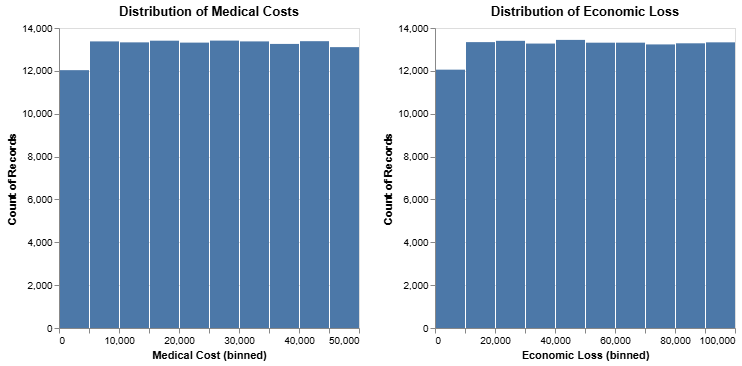

In [8]:
# Histogram of Economic Loss to show distribution  
economic_loss_hist = alt.Chart(accidents).mark_bar().encode(
    alt.X('Economic Loss:Q', bin=alt.Bin(maxbins=10)),
    alt.Y('count()'),
).properties(
    title="Distribution of Economic Loss")

# Histogram of Medical Cost to show distribution 
medical_cost_hist = alt.Chart(accidents).mark_bar().encode(
    alt.X('Medical Cost:Q', bin=alt.Bin(maxbins=10)),
    alt.Y('count()')
).properties(
    title="Distribution of Medical Costs")

medical_cost_hist | economic_loss_hist

**Comments** 
- Economic Loss values range from 1,000.33 to 99,999.62, showing a large range. However, there is a balanced distribution of observations across all of the different bins. 
- Similarly, Medical Cost also has a wide range from 500.11 to 49,999.93 and a balanced distribution. 
- Data is collected from 10 countries, with Canada being the most frequent value 
- Nighttime accidents are the most frequent, so maybe visibility and fatigue are potential factors
- Binary variables like Driver Gender and Urban/Rural have roughly balanced numbers of both cases, so there likely isn't a large class imbalance

#### Multivariate Analysis

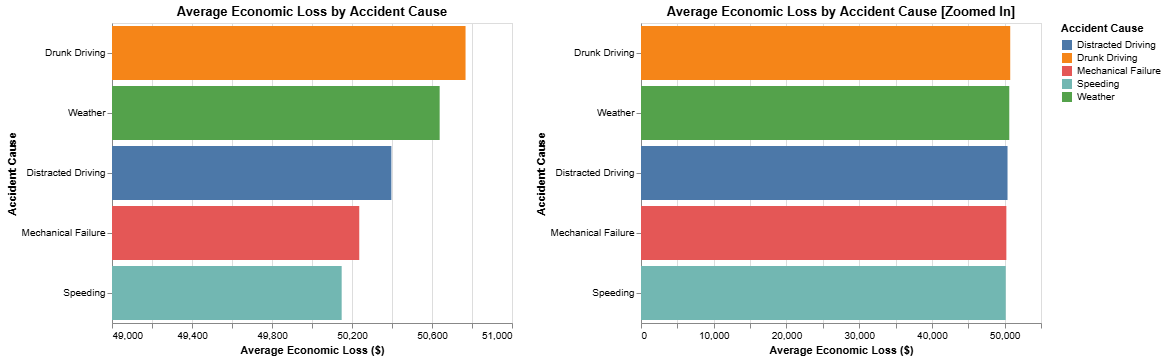

In [13]:
# Bar chart of Accident Cause vs Economic Loss 
causes_barchart = alt.Chart(accidents).mark_bar().encode(
    alt.Y('Accident Cause:N', sort='-x'),
    alt.X('average(Economic Loss):Q', title="Average Economic Loss ($)", scale=alt.Scale(domain=[49000, 51000])),
    alt.Color('Accident Cause:N')
).properties(
    title="Average Economic Loss by Accident Cause", 
    height=300,
    width=400)

causes_zoomed = causes_barchart.encode(alt.X('average(Economic Loss):Q', title="Average Economic Loss ($)")
                                      ).properties(title="Average Economic Loss by Accident Cause [Zoomed In]")

causes_barchart  | causes_zoomed

From the bar charts above, it seems like Economic Loss doesn't vary much overall by Accident Cause and it isn't a good predictor for the cost of an accident. The difference between the cause with the highest average economic loss (Drunk Driving) and lowest (Speeding) is only $619.35.

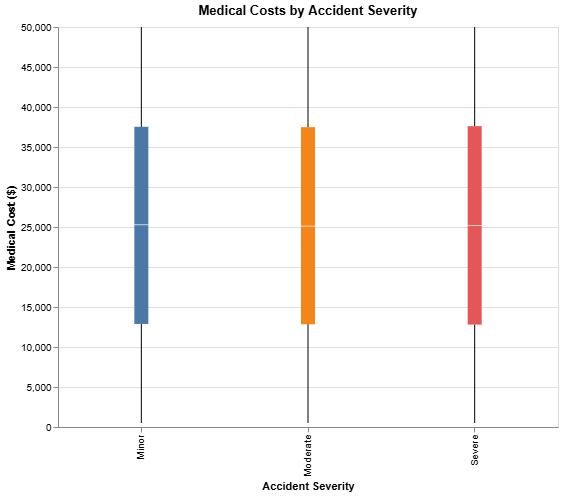

In [14]:
# Boxplot of how Medical Costs vary by Accident Severity 
boxplot_medical_costs = alt.Chart(accidents).mark_boxplot().encode(
    alt.X('Accident Severity:N', title='Accident Severity'),  
    alt.Y('Medical Cost:Q', title='Medical Cost ($)'),       
    alt.Color('Accident Severity:N', legend=None),       
    tooltip=['Accident Severity', 'Medical Cost']               
).properties(
    title="Medical Costs by Accident Severity", 
    height=400,  
    width=500)

boxplot_medical_costs

It doesn't look like Medical Costs vary by Accident Severity. All three levels of severity have near-identical distributions, max and min values, whiskers, and median values. 

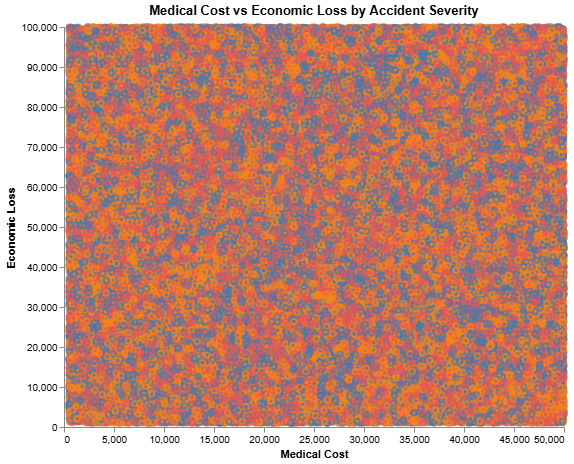

In [11]:
# Scatterplot of Medical Costs and Economic Loss
scatter_medical_economic = alt.Chart(accidents).mark_point().encode(
    alt.X('Medical Cost:Q'), 
    alt.Y('Economic Loss:Q'),     
    alt.Color('Accident Severity:N', legend=None),
    tooltip=['Medical Cost', 'Economic Loss', 'Accident Severity']
).properties(
    title="Medical Cost vs Economic Loss by Accident Severity",
    height=400,  
    width=500) 

scatter_medical_economic

There are no relationships in the scatterplot above. 

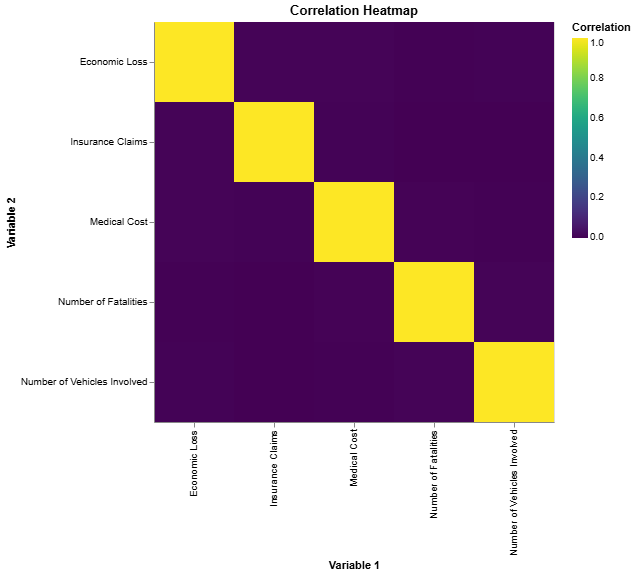

In [12]:
# Heat map for columns related to Economic Loss and Medical Costs 

select_columns = ['Economic Loss', 'Medical Cost', 'Number of Vehicles Involved', 'Number of Fatalities', 'Insurance Claims']

corr_matrix = accidents[select_columns].corr()
corr_matrix_melted = corr_matrix.reset_index().melt(id_vars='index')
corr_matrix_melted.columns = ['Variable1', 'Variable2', 'Correlation']

heatmap = alt.Chart(corr_matrix_melted).mark_rect().encode(
    alt.X('Variable1:N', title='Variable 1'),
    alt.Y('Variable2:N', title='Variable 2'),
    alt.Color('Correlation:Q', scale=alt.Scale(scheme='viridis'), title='Correlation'),
    tooltip=['Variable1', 'Variable2', 'Correlation']
).properties(
    title="Correlation Heatmap",
    height=400,
    width=400)

heatmap

There are no correlations between the variables. 

### Task Analysis

#### Which accident-related factors contribute the most to economic loss, and how does their impact vary by accident severity?
- **Retrieve Value**: Extract Economic Loss, Accident Severity, and potential factors like Number of Vehicles Involved and Accident Cause.
- **Sort**: Sort Economic Loss from high to low to find highest contributing factors. 
- **Filter**: Filter accidents based on Accident Severity.
- **Compute Derived Value**: Calculate the average Economic Loss for categorical variables.
- **Correlate**: Analyze the relationship between Economic Loss and other variables.
- **Characterize Distribution**: Visualize how Economic Loss is distributed across different Accident Severity levels and other factors.
- **Determine Range**: Identify the range of Economic Loss for each Accident Severity level and assess how the range changes across different contributing factors.

#### How do medical costs and total economic loss per accident differ between urban and rural areas?
- **Retrieve Value**: Extract Medical Costs, Economic Loss, and Urban/Rural classifications.
- **Filter**: Filter accidents into Urban and Rural areas.
- **Correlate**: Analyze the relationship between Urban/Rural classification and Medical Costs or Economic Loss.
- **Cluster**: Group accidents based on Urban/Rural and other factors (like Accident Severity) to see if different areas show different patterns of cost.

#### Do speed limits impact the medical costs and economic loss associated with road accidents?
- **Retrieve Value**: Extract Speed Limits, Medical Costs, and Economic Loss for each accident.
- **Characterize Distribution**: Visualize the distribution of Economic Loss and Medical Costs for different Speed Limits.
- **Correlate**: Analyze the relationship between Speed Limit and Medical Costs or Economic Loss, identifying if higher speed limits are correlated with higher costs.